# Multiphase Reactor Modeling

In chemical reactors, reactants are converted into products through chemical reactions. The goal is often to optimize quantities such as yield and selectivity.
In addition to chemical reaction kinetics, transport phenomena such as mixing, mass transfer, and heat transfer play a crucial role in determining reactor performance.
A reactor model aims to describe these phenomena, enabling it to serve as a tool for designing and optimizing reactors.

## A Typical Transport Equation

A common type of model is the convection-diffusion-reaction equation:

$$ \frac{\partial c}{\partial t} + \nabla \cdot (\mathbf{v} \, c - D\nabla c) = r$$

Here, it is written as a single-species equation, but in general, $c$ could represent the concentrations of multiple species, corresponding to different chemical components and their presence in various phases. The 'reaction' term $r$ can include mass-transfer terms (between phases) in addition to reaction kinetics. The diffusion coefficient $D$ might actually represent a dispersion coefficient. In addition to concentrations, temperature can also be modeled using a similar equation. Accumulation terms can be more complex, and there might be counter-flow or other phenomena to consider.

## Discretization of the Reactor Model

The convection-diffusion-reaction equation is a partial differential equation (PDE) that is discretized in space. The `PyMRM` package provides a set of building blocks to easily create such discretizations and efficiently solve them. Phenomenological models, which are the focus of the `PyMRM` package, are typically 1D and sometimes 2D in space. The discretization is performed on a regular grid, which can always be represented by a multi-dimensional array. Different species and phases can also correspond to different dimensions.

To enable efficient (vectorized) computations with these multi-dimensional arrays, the `PyMRM` package extensively uses `Numpy`. For example, consider a 4-dimensional array where `c.shape = (n_x, n_y, n_p, n_c)`. Here, the first two axes (`n_x` and `n_y`) correspond to the spatial $x$ and $y$ directions. The third axis (`n_p`) represents the number of phases, and the fourth axis (`n_c`) represents the number of components. In Python, axis indexing starts at 0, so `axis=2` corresponds to the phases, and `axis=3` corresponds to the components.

In most cases, there will be a (partly) implicit equation that needs to be solved. In the general case of a non-linear equation, we will use Newton-Raphson iteration for that. Inside each iteration, a linear system of equations is solved, i.e., a matrix-vector equation, where the matrix is sparse. For the solution of these sparse-matrix equations, we heavily depend on the `SciPy` package. The sparse matrix representation we use is a compressed column format, `csc_array`, in `SciPy`.

The general transport equation, including reaction, can be seen as a micro balance of accumulation and transport on the left-hand side, with production/consumption on the right-hand side. The transport term is the divergence of a (molar) flux, where the flux has a convective and a diffusion contribution. Sometimes, especially in mathematical writings, a more explicit distinction between the divergence and gradient operators is made. We can then write the equation as:

$$\frac{\partial c}{\partial t} + \mathrm{div}(\mathbf{v} \, c - D \, \mathrm{grad}(c)) = r$$

This is a convenient form because our discretized equations will have a form that looks similar. For example:
```python
(c-c_old)/dt + div_mat @ (conv_mat @ c - D * grad_mat @ c) = r
```
Here, `div_mat` and `grad_mat` are matrices that are discrete approximations of the differential operators $\mathrm{div}$ and $\mathrm{grad}$. `conv_mat` is also a matrix containing velocities. (You might think you could just use `v*c` when `v` is constant, but convection is a bit tricky in relation to numerical stability).

## Stationary Diffusion

Let us consider the stationary diffusion problem, or Poisson equation:

$$\Delta c = f, \text{ or: } \mathrm{div}(\mathrm{grad}(c))=f,$$

This can be discretized as:

```python
(div_mat @ grad_mat) @ c = f
```

Let's consider the case with $f=-1$ and zero values at the wall. In 1D, on the domain $[0,L]$, the equation $c''=-1$ gives $c = \tfrac{1}{2} x (L-x)$. A minimal code to solve this problem in `PyMRM` is:

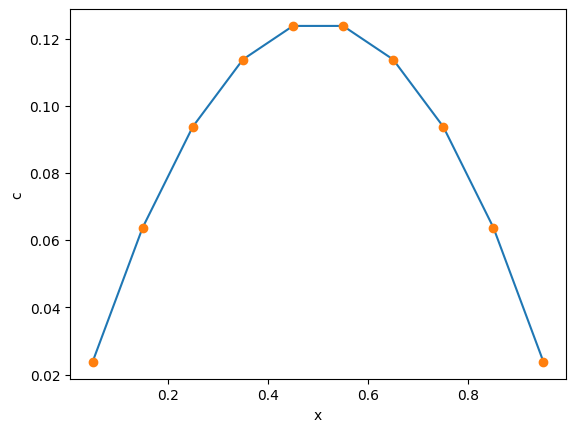

In [4]:
from pymrm import construct_grad, construct_div
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla

L = 1.0 # length of the domain
n_c = 10 # number of cells in the computational domain
shape_c = (n_c,) # shape array c
f = -np.ones(shape_c) # source term

x_f = np.linspace(0, L, shape_c[0]+1) # location of cell faces
x_c = 0.5*(x_f[:-1] + x_f[1:]); # location of cell centers
bc = ({'a':0,'b':1, 'd':0}, {'a':0, 'b':1, 'd':0}) # boundary conditions specification

div_mat = construct_div(shape_c, x_f) # Divergence matrix
grad_mat, grad_bc = construct_grad(shape_c, x_f, x_c, bc=bc) # Gradient matrix
lapl_mat = div_mat @ grad_mat # Laplacian matrix

c = sla.spsolve(lapl_mat, f) # solve the PDE

plt.plot(x_c, c, label='numerical solution')
plt.plot(x_c, 0.5*(x_c*(L-x_c)),'o', label='exact solution')
plt.xlabel('x')
plt.ylabel('c')
plt.show()


### Detailed Explanation

In `PyMRM`, quantities are defined as cell-centered. This is slightly inconvenient because there are two types of positions: face positions `x_f`, which indicate the positions of cell faces, and cell-centered positions `x_c`, where quantities are defined. There is always one more face position than cell-centered positions. This explains the `+1` in `x_f = np.linspace(0, L, shape_c[0]+1)`.

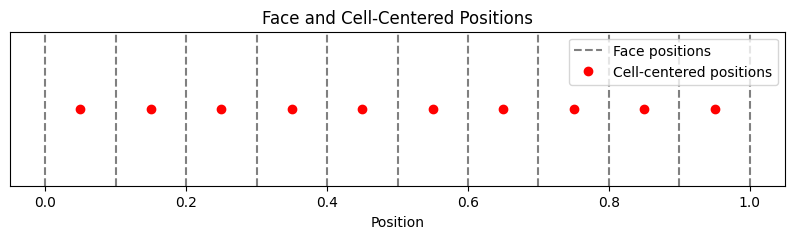

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))  # Adjust figure size to make it rectangular

# Plot face positions as vertical lines
for x in x_f:
    plt.axvline(x, color='gray', linestyle='--', label='Face positions' if x == x_f[0] else '')

# Plot cell-centered positions as dots
plt.plot(x_c, [0] * len(x_c), 'ro', label='Cell-centered positions')

plt.xlabel('Position')
plt.yticks([])  # Remove y-ticks
plt.gca().set_yticklabels([])  # Remove y-labels
plt.title('Face and Cell-Centered Positions')
plt.legend()
plt.show()

This inconvenenience is compensated by modelling convenience. A cell can now be seen as a control volume, with a quantity in the center and fluxes on the faces. For example, gradients are computed from the values in two neighboring cells and are defined on cell faces. The matrix `grad_mat` operates on cell values, and outputs face quantitues. Therefore it is not a square matrix, but its shape is:

In [14]:
print("Shape of the gradient matrix, grad_mat:", grad_mat.shape)

Shape of the gradient matrix, grad_mat: (11, 10)


When computing a divergence, the input are fluxes defined on cell faces. This also explains why `construct_div` only needs face positions, `x_f`, as input. The matrix `div_mat` thus takes values defined on face positions and outputs cell-centered values:

In [15]:
print("Shape of the divergence matrix, div_mat:", div_mat.shape)

Shape of the divergence matrix, div_mat: (10, 11)
